<a href="https://colab.research.google.com/github/ArretVice/neural_style_transfer/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Neural Style Transfer Project**

Research paper: https://arxiv.org/pdf/1508.06576.pdf

In [0]:
from google.colab import files
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from time import time

import tensorflow as tf

from keras.applications import vgg19
from keras.models import Model
from keras.layers import Input, AveragePooling2D
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [0]:
# upload images; style and content images have to be 224x224x3
files.upload()

In [0]:
# change file names according to loaded images' names
content_image_name='content.jpg'
style_image_name='style.jpg'

In [0]:
def prepare_images(content_image_name, style_image_name):
    '''
    Open content and style images for VGG19 net.
    Images have to be 224x224x3 size.
    Returns tuple (content_image, style_image, generated_image)
    '''
    content_image=Image.open(content_image_name)
    style_image=Image.open(style_image_name)
    generated_image=(np.random.random((224,224,3))*255).astype('uint8')
    generated_image=Image.fromarray(generated_image).convert('RGB')
    return (content_image, style_image, generated_image)

In [0]:
# content cost function
def content_loss_func(content_tensor, generated_content_tensor):
    '''Distance between image encodings'''
    return tf.reduce_sum(tf.square(content_tensor-generated_content_tensor))/2

In [0]:
def gram_matrix(tensor):
    '''Compute Gram matrix'''
    _, height, width, channels=tensor.get_shape().as_list()
    reshaped_tensor=tf.reshape(tensor, (height*width, channels))
    gram_matrix=tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)/2
    return gram_matrix

In [0]:
# style loss function
def style_loss_func(style_tensors, generated_style_tensors):
    '''Returns the tuple with style losses'''
    res=()
    for style_tensor, generated_style_tensor in zip(style_tensors, generated_style_tensors):
        gram_style=gram_matrix(style_tensor)
        gram_generated=gram_matrix(generated_style_tensor)
        _, height, width, channels=style_tensor.get_shape().as_list()
        loss=tf.reduce_sum(tf.square(gram_generated-gram_style))
        normalization_constant=1/((2*height*width*channels)**2)
        loss*=normalization_constant
        res+=loss,
    return res

In [0]:
######## main ########

# prepare images
content_image, style_image, generated_image=prepare_images(content_image_name, style_image_name)

# preprocess images
content_image=np.array(content_image).reshape(1,224,224,3)/255
style_image=np.array(style_image).reshape(1,224,224,3)/255
generated_image=np.array(generated_image).reshape(1,224,224,3)/255


# input tensors
content_input_tensor=K.constant(content_image)
style_input_tensor=K.constant(style_image)
generated_image_tensor=K.variable(generated_image)


# load pretrained model
pretrained_model=vgg19.VGG19(weights='imagenet', include_top=False)


# the article suggested using average pooling instead of max pooling, so let's rebuild model
# pooling layers are at indices [3, 6, 11, 16, 21]
x=pretrained_model.layers[0].output
for index in range(1, len(pretrained_model.layers)):
    if index in [3, 6, 11, 16, 21]:
        x=AveragePooling2D(name='AvgPool_'+str(index))(x)
    else:
        x=pretrained_model.layers[index](x)

custom_pretrained_model=Model(inputs=pretrained_model.layers[0].input, outputs=x)
#custom_pretrained_model=Model(inputs=pretrained_model.layers[0].input, outputs=pretrained_model.layers[-1].output) # unchanged model


# create style and content encoders for images
# content encoding branch of model
content_encoder=Model(inputs=custom_pretrained_model.layers[0].input,
                      outputs=custom_pretrained_model.get_layer('block1_conv1').get_output_at(-1))


# style layers
selected_style_layers=[
    custom_pretrained_model.get_layer('block1_conv2').get_output_at(-1),
    custom_pretrained_model.get_layer('block2_conv2').get_output_at(-1),
    custom_pretrained_model.get_layer('block3_conv2').get_output_at(-1),
    custom_pretrained_model.get_layer('block4_conv2').get_output_at(-1),
    custom_pretrained_model.get_layer('block5_conv2').get_output_at(-1)
]


# style encoding branch of model
style_encoder=Model(inputs=custom_pretrained_model.layers[0].input,
                    outputs=selected_style_layers)


# prepare tensors for further calculations
content_tensor=content_encoder(content_input_tensor)
generated_content_tensor=content_encoder(generated_image_tensor)
style_tensors=style_encoder(style_input_tensor)
generated_style_tensors=style_encoder(generated_image_tensor)


# get loss tensors
content_loss=content_loss_func(content_tensor, generated_content_tensor)
style_losses=style_loss_func(style_tensors, generated_style_tensors)

In [0]:
# see the structure of the model
#custom_pretrained_model.summary()

In [0]:
# visual representation
#SVG(model_to_dot(custom_pretrained_model).create(prog='dot', format='svg'))

In [0]:
# model parameters
style_layer_weights=[0.33, 0.33, 0.33, 0, 0]
content_weight=1e-5
style_weight=1
learning_rate=0.1

# total loss
style_loss=np.sum([x*y for x, y in zip(style_layer_weights, style_losses)])
total_loss=content_weight*content_loss+style_weight*style_loss

In [0]:
# backpropagation
backprop=tf.train.AdamOptimizer(learning_rate).minimize(total_loss, var_list=[generated_image_tensor])
#backprop=tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss, var_list=[generated_image_tensor])

In [307]:
# begin training
n_epochs=100
generated_images=[]

with tf.Session() as sess:
    t0=time()
    sess.run(tf.global_variables_initializer())
    for epoch in range(1,n_epochs+1):
        sess.run(backprop)
        if (epoch%(n_epochs//5)==0) or (epoch==1) or (epoch==n_epochs):
            print(f'Epoch {epoch}: Content loss: {sess.run(content_loss*content_weight)}; Style loss: {sess.run(style_loss*style_weight)}; Total loss: {sess.run(total_loss)}')
            generated_images.append((generated_image_tensor.eval().reshape(224,224,3)*255).astype('uint8'))
    t1=time()
    print(f'Done with session, time to execute: {t1-t0:.2f} sec')

Epoch 1: Content loss: 0.050207026302814484; Style loss: 1.3260992659525073e-07; Total loss: 0.05020716041326523
Epoch 20: Content loss: 0.0027201534248888493; Style loss: 1.0570614961125102e-07; Total loss: 0.002720259130001068
Epoch 40: Content loss: 0.00037815526593476534; Style loss: 1.0783840309613879e-07; Total loss: 0.00037826309562660754
Epoch 60: Content loss: 5.165293623576872e-05; Style loss: 1.0648572867921757e-07; Total loss: 5.17594235134311e-05
Epoch 80: Content loss: 6.7920204855909105e-06; Style loss: 1.0644939862913816e-07; Total loss: 6.8984700192231685e-06
Epoch 100: Content loss: 8.770389854362293e-07; Style loss: 1.064216732515888e-07; Total loss: 9.834606089498266e-07
Done with session, time to execute: 230.19 sec


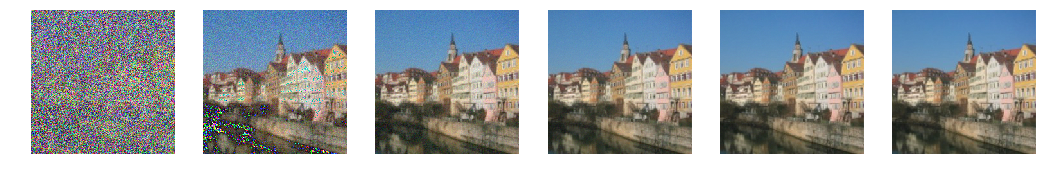

In [308]:
# show generated images
fig=plt.figure(figsize=(18,18))
for n, image in enumerate(generated_images):
    a = fig.add_subplot(1, len(generated_images), n + 1)
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(image)
plt.show()